In [1]:
import os
import json

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.transform import (
    sequence_embedding, 
    normalize, denormalize,
    make_dataset_balanced,
    one_hot_encode_classes,
    split_train_test_set,
)
from rna_learn.load import load_mrna_model, load_dataset
from rna_learn.model import conv1d_classification_model

In [2]:
sns.set(palette='colorblind', font_scale=1.3)

In [3]:
alphabet = ['A', 'T', 'G', 'C']
classes = ['psychrophilic', 'mesophilic', 'thermophilic']

In [4]:
run_id = 'run_1eo28'
model_path = os.path.join(os.getcwd(), f'hyperparameters/{run_id}/best_model.h5')
test_set_path = os.path.join(os.getcwd(), 'data/dataset_test.csv')

In [5]:
model = load_model(model_path)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, None, 4)]         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 100)         4100      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 100)         100100    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 100)         100100    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 100)         100100    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0   

In [6]:
dataset_df = load_dataset(test_set_path, alphabet)
dataset_df.head()

,specie_name,seqid,gene_name,start_inclusive,end_exclusive,length,strand,temperature,temperature_range,sequence,gc_content
0,Micropolyspora internatus,NC_013159.1,rnpB,742238,742645,407,+,45.0,thermophilic,CGAGTTGGCAGGGCGGCCGCGGCCGAGGGCATCGTCTCGACGTCTT...,0.685504
1,Listonella anguillarum,NC_015633.1,recA,2753532,2754579,1047,-,20.0,psychrophilic,ATGGACGAAAATAAGCAGAAGGCGCTAGCCGCAGCACTGGGTCAAA...,0.442216
2,Comamonas badia,NZ_AXVM01000006.1,rpsR,29593,29878,285,-,28.0,mesophilic,TTGACCATGTTCAGGAAATTCAACAAGAATGGCAAGAACGGCAAGC...,0.568421
3,Acetobacter orientalis,NZ_BAMX01000009.1,tsaD,11584,12799,1215,-,30.0,mesophilic,ATGGCGGTCAGCAGCCAGTTTTCAGGCTTACCCGGCACCCCTCACA...,0.596708
4,Alicyclobacillus kakegawensis,NZ_BCRP01000001.1,tsaD,64880,65918,1038,-,50.0,thermophilic,TTGCTCCTGTTGGGCATTGAGACGAGTTGCGACGAGACCGCCGCGG...,0.680154


In [7]:
sequences = dataset_df['sequence'].values
temperature_classes = dataset_df['temperature_range'].values

x_test = sequence_embedding(sequences, alphabet)
y_test = one_hot_encode_classes(temperature_classes, classes)

In [8]:
%%time
model.evaluate(x_test, y_test, verbose=0)

CPU times: user 3min 40s, sys: 2.02 s, total: 3min 42s
Wall time: 32.3 s


[0.9927175012794701, 0.5016216]

In [9]:
%%time
y_pred = model(x_test)

labels = [np.argmax(el) for el in y_test]
predictions = [np.argmax(el) for el in y_pred]

CPU times: user 4min 11s, sys: 1min 5s, total: 5min 16s
Wall time: 1min 3s


In [10]:
def plot_confusion_matrix(labels, predictions, classes):
    conf = tf.math.confusion_matrix(labels, predictions).numpy()
    conf_sum = np.sum(conf, axis=1)
    conf_p = conf / conf_sum
    
    df_cm = pd.DataFrame(
        conf_p, 
        index=[f'{c}: {i}' for i, c in enumerate(classes)],
        columns=[f'{i}' for i, c in enumerate(classes)],
    )
    ax = sns.heatmap(df_cm, cmap="Purples", annot=True, fmt='.0%', cbar=False);
    ax.set_xlabel('Predictions');
    ax.set_ylabel('Labels');

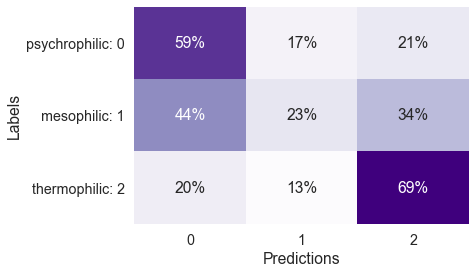

In [11]:
plot_confusion_matrix(labels, predictions, classes)

## VAE